In [2]:
import numpy as np
import matplotlib.pyplot as plt
import ehtim as eh
from tqdm.notebook import tqdm
import functools

import jax
import flax
from jax import numpy as jnp
from flax import linen as nn
from flax.training import train_state
from typing import Any, Callable
import optax
import sys
from flax.serialization import from_bytes
from flax.serialization import to_bytes

from datetime import datetime


Welcome to eht-imaging! v 1.2.10 



Loading text image:  avery_sgra_eofn.txt


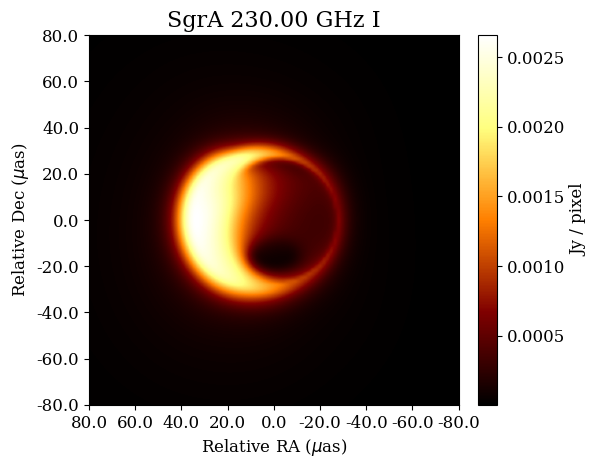

OBSERVED
Producing clean visibilities from image with nfft FT . . . 


In [ ]:
image_path = 'datasets/avery_sgra_eofn.txt'
array_path = 'datasets/EHT2017.txt'
image_true = eh.image.load_txt(image_path)
array = eh.array.load_txt(array_path)
image_true.display()

tint = 5
tadv = 600
tstart_hr = 0
tstop_hr = 24

obs = array.obsdata(tint=tint, tadv=tadv, tstart=tstart_hr, tstop=tstop_hr, ra=image_true.ra, 
                    dec=image_true.dec, rf=image_true.rf, mjd=image_true.mjd,
                    bw=image_true.rf, timetype='UTC', polrep='stokes')
print("OBSERVED")
# observe no noise 
obs = image_true.observe_same_nonoise(obs) 

In [4]:
def shard(xs):
    """Split data into shards for multiple devices along the first dimension."""
    return jax.tree_util.tree_map(lambda x: x.reshape((jax.local_device_count(), -1) + x.shape[1:]), xs)
# split among n-devices. x.shape[1:] = (,features) -> inside of parens = (devices, -1, features).

def flattened_traversal(fn):
    def mask(data):
        flat = flax.traverse_util.flatten_dict(data)
        return flax.traverse_util.unflatten_dict({k: fn(k, v) for k, v in flat.items()})
    return mask
#NOTES: take a nested dict of model params {"Dense_0": 'kernel':..., "bias":...}...} into ("dense_0", "kernel"): ...
# used to mask certain parameters. 

class MLP(nn.Module): #define a flax network
    net_depth: int = 4 #how many layers
    net_width: int = 128 #how many neurons in each hidden layer
    activation: Callable[..., Any] = nn.relu 
    out_channel: int = 1 #number of alpha_channels
    do_skip: bool = True #skip connection every net_depth // 2 layers. helps gradient flow and learning residuals
  
    @nn.compact #this allows us to define submodules like nn.dense
    def __call__(self, x):
        """A simple Multi-Layer Preceptron (MLP) network

        Parameters
        ----------
        x: jnp.ndarray(float32), 
            [batch_size * n_samples, feature], points.
        net_depth: int, 
            the depth of the first part of MLP.
        net_width: int, 
            the width of the first part of MLP.
        activation: function, 
            the activation function used in the MLP.
        out_channel: 
            int, the number of alpha_channels.
        do_skip: boolean, 
            whether or not to use a skip connection

        Returns
        -------
        out: jnp.ndarray(float32), 
            [batch_size * n_samples, out_channel].
        """
        dense_layer = functools.partial(
            nn.Dense, kernel_init=jax.nn.initializers.he_uniform()) #a default initializer for each Dense layer. includes submodule declaration hence, @nn.compact()

        if self.do_skip:
            skip_layer = self.net_depth // 2 
            #we'll concatenate original input once, halfway through the network at layer index = skip_layer

        inputs = x
        for i in range(self.net_depth): 
            x = dense_layer(self.net_width)(x) #1) dense_layer(self.net_width) -> dense layer with feature count net_width, kernel_init = he_uniform 
            #2) ...(x)applies layer to the data. Run forward pass x @ W + b
            x = self.activation(x) #apply activation function to array x. 
            if self.do_skip:
                if i % skip_layer == 0 and i > 0:
                    x = jnp.concatenate([x, inputs], axis=-1) #-> [batch, net_width + input_dim]. has deep features and direct path back to untransformed inputs, preserving low level info.
        out = dense_layer(self.out_channel)(x) #out = [batch, out_channel=1]

        return out

#NOTE: Neural nets have trouble learning high-frequency variations in direct coordinate space. 
# To solve this, map (x,y) on the image plane into a higher dimensional space of sines and cosines at multiple frequencies.      
def posenc(x, deg):
    """
    Concatenate `x` with a positional encoding of `x` with degree `deg`.
    Instead of computing [sin(x), cos(x)], we use the trig identity
    cos(x) = sin(x + pi/2) and do one vectorized call to sin([x, x+pi/2]).

    Parameters
    ----------
    x: jnp.ndarray, 
        variables to be encoded. Note that x should be in [-pi, pi].
    deg: int, 
        the degree of the encoding.

    Returns
    -------
    encoded: jnp.ndarray, 
        encoded variables.
    """
    if deg == 0:
        return x
    scales = jnp.array([2**i for i in range(deg)]) # [1, 2, 4, ..., 2^deg-1], frequencies at which to sample coordinates
    xb = jnp.reshape((x[..., None, :] * scales[:, None]), # [..., None, :] insert a new axis before the last dim, [:, None] insert a new axis after the last scale dim
                     list(x.shape[:-1]) + [-1]) #if x is (N, D) n points in D dims, x[..., None, :] - > shape(N, 1, D), scales[:, None] -> (deg, 1)
    #product: broadcast (deg, 1) -> (1, deg, 1), combine max(i_1, i_2) -> (N, deg, D). N points, each expanded into deg copies of the D-dimensional coordinates

    #x.shape = (N, D) -> x.shape[:-1] = (N,). ->[N, -1]. reshape(..., [N,-1]) = make first dimension N, pack all remaining elements into the second dimension... will be N * deg * D / N = deg * D elements 
    #ex: [1,2], [3, 4] -> [ [[1, 2]], [[3, 4]] ] scales = [ [1], [2], [3] ] -> x * scales = [ [[1, 2], [3, 4]], [[2, 4], [6, 8]], [[4, 8], [12, 16]] ] -> [ [1, 2, 2, 4, 4, 8], [3, 4, 6, 8, 12, 16] ]

    four_feat = safe_sin(jnp.concatenate([xb, xb + 0.5 * jnp.pi], axis=-1)) #use a safe sin to prevent blowups, concatenate so we have both sin argument and cos argument. do this along the y axis (element wise in the list)
    return jnp.concatenate([x] + [four_feat], axis=-1) #add back the original x, y points to beginning of x , y lists. 

# wrapper around the MLP module to predict and forward pass. 
class NeuralImage(nn.Module):
    """
    Full function to predict emission at a time step.
    
    Parameters
    ----------
    posenc_deg: int, default=3
    net_depth: int, default=4
    net_width: int, default=128
    activation: Callable[..., Any], default=nn.relu
    out_channel: int default=1
    do_skip: bool, default=True
    """
    posenc_deg: int = 3
    net_depth: int = 4
    net_width: int = 128
    activation: Callable[..., Any] = nn.relu
    out_channel: int = 1
    do_skip: bool = True
    
    @nn.compact
    def __call__(self, coords):
        image_MLP = MLP(self.net_depth, self.net_width, self.activation, self.out_channel, self.do_skip)
        def predict_image(coords):
            net_output = image_MLP(posenc(coords, self.posenc_deg))
            image = nn.sigmoid(net_output[..., 0] - 10.) # ... -> skip over all preceeding dimensions, access the element 0 in the last dimension. 
            # Shift the sigmoid input back so model learns to push the logit up into an appropriate range. 
            return image
        return predict_image(coords)
    
safe_sin = lambda x: jnp.sin(x % (100 * jnp.pi))

In [5]:
def loss_fn(params, predictor_fn, target, A, sigma, coords):
    '''
    Args:
        params: pytree (nested dict) of all of the model's weights and biases. 
        predictor_fn: the model's apply function
        target: measured intensities
        A: measurement matrix
        sigma: Thermal noise per visibility
        coords: array of shape (N_pixels, 2) with all (x,y) grid coords
    
    Returns:
        image: predicted intensities -> image
        loss: 
    '''
    image = predictor_fn({'params': params}, coords) # evanluate the neural image model at each (x, y)
    vis = jnp.matmul(A, image.ravel()) # return a view (no copy) if possible of image as a 1D array -> 
    loss = jnp.mean((jnp.abs(vis - target)/sigma)**2)
    return loss, [image]

@jax.jit
def train_step(state, target, A, sigma, coords):
    (loss, [image]), grads = jax.value_and_grad(loss_fn, argnums=(0), has_aux=True)(state.params, state.apply_fn, target, A, sigma, coords)
    grads = jax.lax.pmean(grads, axis_name='batch')
    state = state.apply_gradients(grads=grads)
    return loss, state, image

predictor = NeuralImage()
train_pstep = jax.pmap(train_step, axis_name='batch', in_axes=(0, 0, 0, 0, None))
print(jax.local_device_count())

4


In [10]:
"""
Run optimization. Note that this requieres tensorboard and tensorboardX for logging.
To remove tensorboard logging comment out the lines with # logging
"""

log_period = 100
logdir = './runs/imaging_test/test1.{}'.format(datetime.now().strftime('%Y-%m-%d.%H:%M:%S')) # logging

target = obs.data['vis']

# Image coordinates for reconstruction (maybe this could be pertubed every iteration)
npix = 100
fov = 1*image_true.fovx()
prior = eh.image.make_square(obs, npix, fov)
vis, sigma, A = eh.imaging.imager_utils.chisqdata_vis(obs, prior, mask=[])
x, y = np.linspace(0, 1, prior.xdim), np.linspace(0, 1, prior.ydim)
coords = np.moveaxis(np.array(np.meshgrid(x, y, indexing='ij')), 0, -1)

hparams = {'num_iters': 10000, 'lr_init': 1e-3, 'lr_final': 1e-4, 'batchsize': 500}
#SEED = int(sys.argv[1])
params = predictor.init(jax.random.PRNGKey(1), coords)['params']
tx = optax.adam(learning_rate=optax.polynomial_schedule(hparams['lr_init'], hparams['lr_final'], 1, hparams['num_iters']))
state = train_state.TrainState.create(apply_fn=predictor.apply, params=params, tx=tx)  # TODO(pratul): this unfreeze feels sketchy

# Replicate state for multiple gpus
state = flax.jax_utils.replicate(state)
for i in tqdm(range(hparams['num_iters']), desc='iteration'):
    batch = np.random.choice(range(len(target)), hparams['batchsize'], replace=False)
    loss, state, image = train_pstep(state, shard(target[batch, ...]), shard(A[batch, ...]), shard(sigma[batch, ...]), coords)
    #loss, state, image = train_step(state, target[batch, ...], A[batch, ...], sigma[batch, ...], coords)
    

# Unreplicate state
state = jax.device_get(flax.jax_utils.unreplicate(state))

fname = f"black_hole_params.msgpack"  
with open(fname, "wb") as fp:  
    fp.write(to_bytes(state.params))  
print(f"saved params to {fname}")

iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

saved params to black_hole_params.msgpack


In [11]:
print(target.shape)
print(coords.shape)

(1030,)
(100, 100, 2)


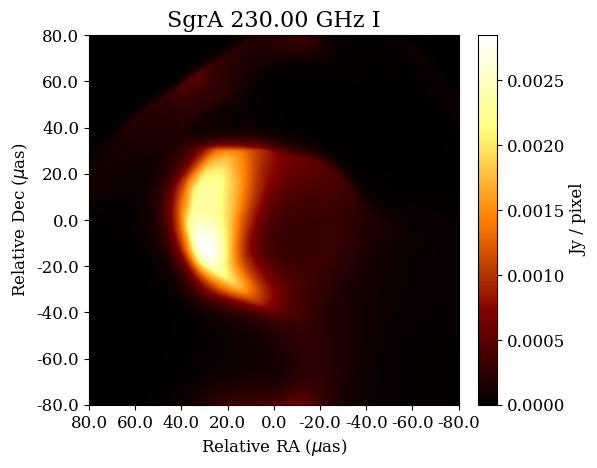

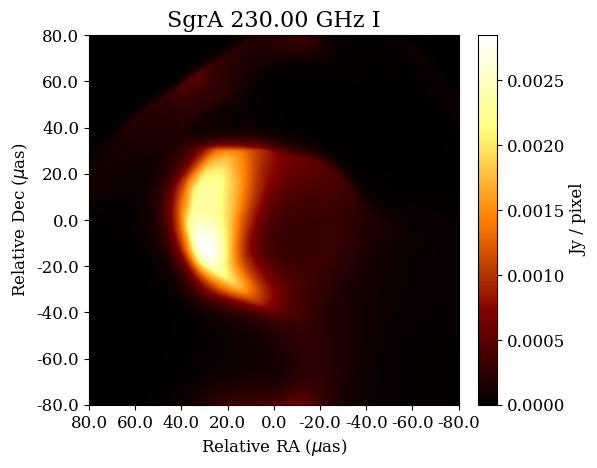

In [12]:
# Sample recostructed continuous image at higher resolution  
npix = 400
image_rec = eh.image.make_square(obs, npix, fov)
x, y = np.linspace(0, 1, image_rec.xdim), np.linspace(0, 1, image_rec.ydim)
coords = np.moveaxis(np.array(np.meshgrid(x, y, indexing='ij')), 0, -1)
image_data = predictor.apply({'params': state.params}, coords)
image_rec.imvec = image_data.ravel()

image_rec.display()

In [ ]:
import os

npix = 100
fov = 1*image_true.fovx()
x, y = np.linspace(0, 1, npix), np.linspace(0, 1, npix)
coords = np.moveaxis(np.array(np.meshgrid(x, y, indexing='ij')), 0, -1)

ensemble = []
preds = []
predictor = NeuralImage()
template = predictor.init(jax.random.PRNGKey(0), coords)['params']
for fname in sorted(os.listdir("bh_ensemble/models")):
    if not fname.endswith(".msgpack"): 
        continue
    data = open(os.path.join("ensembles", fname), "rb").read()
    params = from_bytes(template, data)
    ensemble.append(params)
    preds.append(np.array(predictor.apply({"params": params}, coords)))

E = np.stack(preds, axis=0)
mean_img = E.mean(axis=0)
std_img = E.std(axis=0)



Ensemble mean


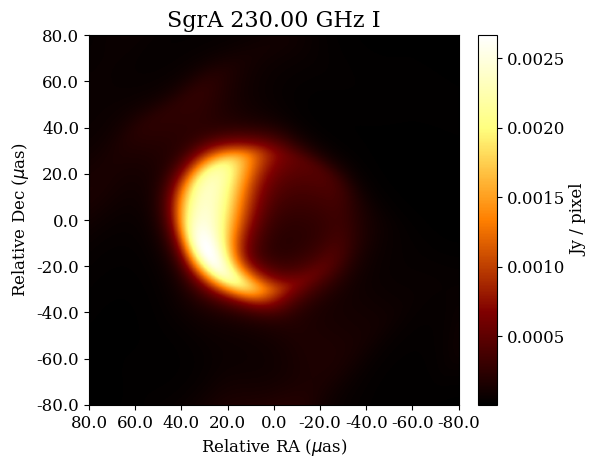

Ensemble STD


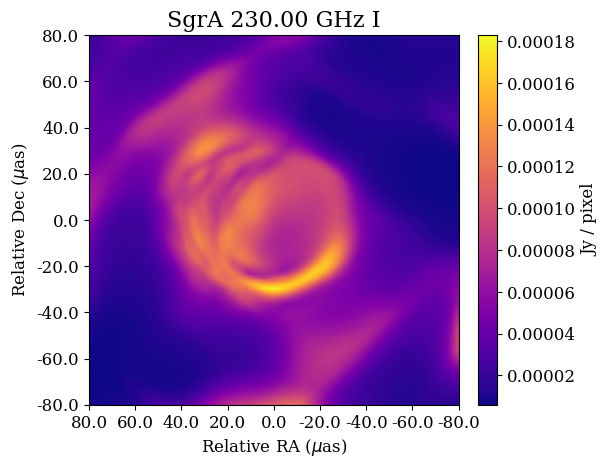

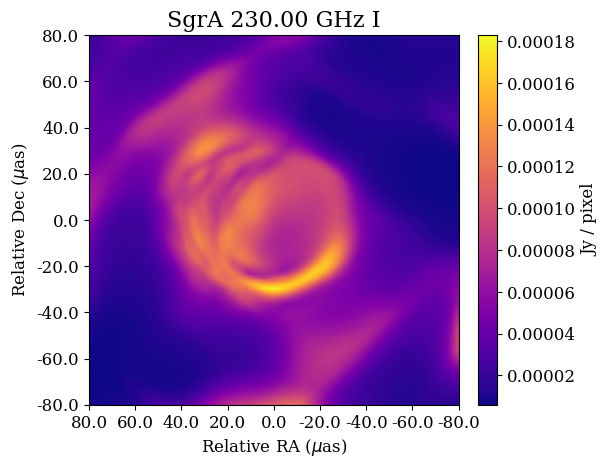

: 

: 

In [ ]:
image_m = eh.image.make_square(obs, npix, fov)
image_std = eh.image.make_square(obs, npix, fov)

image_m.imvec = mean_img.ravel()
image_std.imvec = std_img.ravel()

print("Ensemble mean")
image_m.display()
print("Ensemble STD")
image_std.display(cfun='plasma')

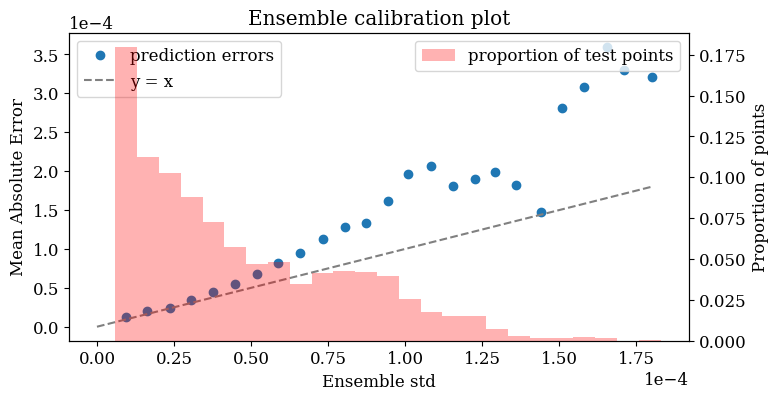

In [20]:
"""
plot the binned points, overlay with bar chart showing num of poitns in each bin
do by percentile
see brandon paper, revailng cosmic web

"""

# compute the correlation plot
gt = image_true.imvec.astype(np.float64)
mean = mean_img.T.astype(np.float64).ravel(order='F')
unc = std_img.T.astype(np.float64).ravel(order='F')
err = np.abs(mean - gt)

order_err = np.argsort(-err)
order_unc = np.argsort(-unc)

N = err.size

# build bins
num_bins = 25
percentiles = np.linspace(0, 100, num_bins + 1)
bin_edges = np.linspace(unc.min(), unc.max(), num_bins+1)
bin_idx = np.digitize(unc, bin_edges) - 1
bin_idx = np.clip(bin_idx, 0, num_bins-1)

bin_centers=0.5*(bin_edges[:-1]+bin_edges[1:])
bin_mean_unc = np.zeros(num_bins)
bin_mean_err = np.zeros(num_bins)
bin_counts = np.zeros(num_bins, dtype=int)

# compute mean and std for each bin
for b in range(num_bins):
    mask = bin_idx == b
    bin_counts[b] = mask.sum()
    if bin_counts[b] > 0:
        bin_mean_unc[b] = unc[mask].mean()
        bin_mean_err[b] = err[mask].mean()
    else:
        bin_mean_unc[b] = bin_centers[b]
        bin_mean_err[b] = np.nan

figure, ax1 = plt.subplots(figsize=(8,4))
ax1.plot(bin_mean_unc, bin_mean_err, 'o', label='prediction errors')
ax1.plot([0, bin_mean_unc.max()], [0, bin_mean_unc.max()], '--', color='gray', label='y = x')
ax1.set_xlabel('Ensemble std')
ax1.set_ylabel('Mean Absolute Error')
ax1.legend(loc='upper left')
ax1.ticklabel_format(style='sci', axis='x', scilimits=(0,0)) #scientific formatting
ax1.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

ax2 = ax1.twinx()
ax2.hist(unc, bins=bin_edges, weights=np.ones_like(unc)/len(unc), color='red', alpha = 0.3, label='proportion of test points')
ax2.set_ylabel('Proportion of points')
ax2.legend(loc='upper right')

plt.title('Ensemble calibration plot')
plt.show()